# Preprocessing Datasets and Segmenting Characters:

## Introduction:
This notebook shows an overview of the steps taken to identify the words in a given image and segment the characters from the detected words. The functions that are showcased here are also available in the `preprocess.py` module.

# Import Packages:
The packages below are used to compile the notebook.

In [1]:
## Import necessary packages.
import cv2
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
from craft_text_detector import Craft

# Initialize Working Directory:
Make sure that the notebook's workspace is located in the root folder of this project so that it can have access to all the modules and datasets.

In [2]:
## Initialize the base directory to be in root folder.
base_dir = os.path.abspath(os.path.join('.', '..'))

Also, make sure to set multiple Open Multi-Processing libraries to true for the CRAFT algorithm to work correctly.

In [3]:
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# Get Image Array:
This project has a few test images for the OCR system. These images are located in the `datasets/images` folder. You can also add your own personal images if you would like. For this notebook, I'll be using the `stop_sign.jpg`.

In [4]:
## Define the image path.
img_path = os.path.join(base_dir, 'datasets', 'images', 'stop_sign.jpg')

## Load in image using PIL Image.
## You can also change the file path to another image.
img = Image.open(img_path)

## Convert image to an image array.
img = np.array(img)

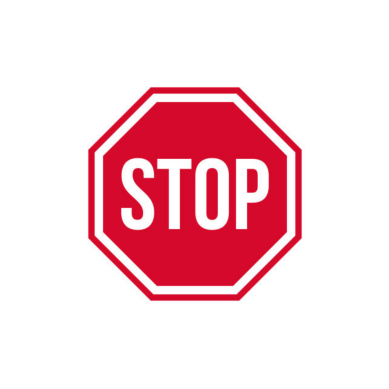

In [5]:
## Show image using matplotlib to make sure it was loaded in correctly.
plt.imshow(img)
plt.axis('off')
plt.show()

# CRAFT Text Detection Algorithm:
## Applying CRAFT Algorithm:
To detect the text in the image, I'll be using the Character-Region Awareness For Text (CRAFT) detection algorithm. The CRAFT algorithm was devloped at NAVER Corporation for segmenting words in images. The algorithm uses the VGG-16 layout to identify the region and affinity score for characters in an image. The region scores indicates the locations that are most likely to contain characters while the affinity scores predicts the connectivity of the potential characters. By combining the two techniques, the CRAFT algorithm is able to create a bounding box around the words presented in a given image. 

For this project, I used the craft-text-detector python package uploaded by fcakyon. Below shows the demonstration of the CRAFT algorithm on the stop sign image.

In [6]:
text_result = Craft().detect_text(image = img)

The CRAFT algorithm will output the corner coordinates of the bounding box for each detected word as well as the region and affinity scores. We can overlay the predicted box onto our image to see if it detected the word correctly.

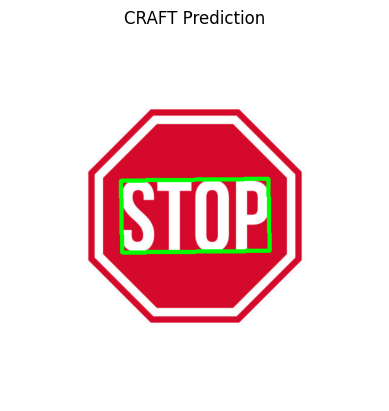

In [7]:
## Create a copy of the image for showcasing the bounding box.
img_demo = img.copy()

## Draw the bounding box for each detected word.
for box in text_result['boxes']:
    cv2.polylines(img_demo, [box.astype(int)], True, (0, 255, 0), 5)

plt.imshow(img_demo)
plt.axis('off')
plt.title("CRAFT Prediction")
plt.show()

## Segmenting Detected Words:
Given the bounding box coordinates, we can now isolate the word that was detected by the CRAFT algorithm. This is done so that all the background noise is removed and the detected word fills up a large portion of the image. Hence, it becomes very helpful when we segment individual characters using the thresholding technique.

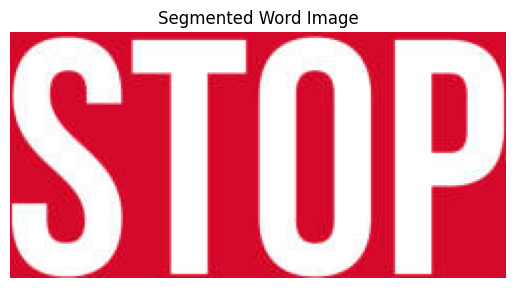

In [8]:
for box in text_result['boxes']:
    ## Extract the image within the bounding box.
    word_img = img[int(min(box[:, 1])):int(max(box[:, 1])), 
                   int(min(box[:, 0])):int(max(box[:, 0]))]
    
    ## Visualize extracted word image.
    plt.imshow(word_img)
    plt.axis('off')
    plt.title("Segmented Word Image")
    plt.show()

## CRAFT Algorithm on Rotated Text:
Before we implement character segmentation, we also have to take into consideration of image morphology. The CRAFT algorithm can detect words that are curved, rotated, etc. While this project couldn't take into consideration for all the morphologies the CRAFT algorithm can cover, I made sure to address any rotated words. We can obtain the rotation matrix of the image and un-rotate the image by using `opencv`'s image operations. After that, we can isolate the un-rotated bounding box for character segmentation.

Below shows the implementation of obtaining the rotation angle of the image as well as un-rotating the image to make it horizontal and obtaining the word image. For this demonstration, we'll use another image that has a rotated text.

In [9]:
## Path to rotated text image.
rot_path = os.path.join(base_dir, 'datasets', 'images', 'rotated_text.jpg')

## Load in the rotated text image using Pillow and convert it to an image array.
rot_img = Image.open(rot_path)
rot_img = np.array(rot_img)

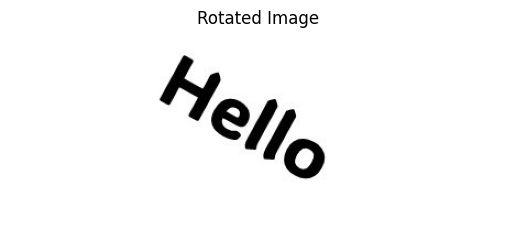

In [10]:
## Display the rotated text image.
plt.imshow(rot_img)
plt.axis('off')
plt.title("Rotated Image")
plt.show()

Follow the previous steps by using the CRAFT algorithm.

In [11]:
## Apply the CRAFT algorithm to detect rotated text.
rot_result = Craft().detect_text(image = rot_img)

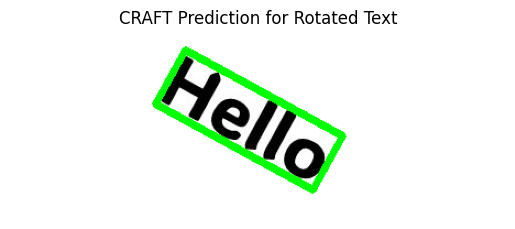

In [12]:
## Create a copy of the rotated image for showcasing the bounding box.
rot_demo = rot_img.copy()

## Draw the bounding box for each detected word.
for rot_box in rot_result['boxes']:
    cv2.polylines(rot_demo, [rot_box.astype(int)], True, (0, 255, 0), 5)

plt.imshow(rot_demo)
plt.axis('off')
plt.title("CRAFT Prediction for Rotated Text")
plt.show()

To find the rotation angle and the coordinates of the rotated bounding box, we'll first use a combination of `cv2.minAreaRect` and `cv2.boxPoints`. The `minAreaRect` returns the center, the size, and the angle of rotation for the detected rectangle. The `boxPoints` returns the four coordinates of the `minAreaRect` object. Below shows the obtained rotational axis in comparison to the x and y axis.

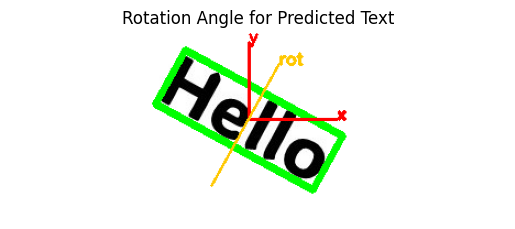

In [13]:
## Make a new demonstration image.
axis_demo = rot_demo.copy()

## For each detected text, find the angle of rotation.
for rot_box in rot_result['boxes']:
    ## Get the center, size, and angle of rotation for bounding box.
    rot_rect = cv2.minAreaRect(rot_box)
    ## Get the four coordinates of bounding box.
    rot_coords = cv2.boxPoints(rot_rect)
    ## Convert the coordinates into integers for plotting.
    rot_coords = np.int0(rot_coords)

    ## Get the center coordinates of the bounding box.
    center_y = int(rot_rect[0][0])
    center_x = int(rot_rect[0][1])

    ## Get the slop of the rotational axis.
    rot_slope = (rot_coords[0][0] - rot_coords[1][0]) / (rot_coords[0][1] - rot_coords[1][1])

    ## Get the horizontal, vertical axis, and rotation axis.
    x_axis = ((center_y, center_x), (center_y + 80, center_x))
    y_axis = ((center_y, center_x), (center_y, center_x - 70))
    rot_axis = ((int(center_y - (50 * rot_slope)), int(center_x - 50)), (int(center_y + (60 * rot_slope)), int(center_x + 60)))

    ## Draw the x and y axis on the image.
    cv2.line(axis_demo, (x_axis[0]), (x_axis[1]), (255, 0, 0), 2)
    cv2.line(axis_demo, (y_axis[0]), (y_axis[1]), (255, 0, 0), 2)
    cv2.line(axis_demo, (rot_axis[0]), (rot_axis[1]), (255, 200, 0), 2)

    ## Add the axis names for each drawn lines.
    cv2.putText(axis_demo, 'x', x_axis[1], cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
    cv2.putText(axis_demo, 'y', y_axis[1], cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
    cv2.putText(axis_demo, 'rot', rot_axis[0], cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 200, 0), 2)

    ## Visualize the rotational axis with respect to the x and y axis.
    plt.imshow(axis_demo)
    plt.axis('off')
    plt.title("Rotation Angle for Predicted Text")
    plt.show()    

In order to un-rotate the image, we'll first have get the rotation matrix using `cv2.getRotationMatrix2D`. This gives us the matrix needed to rotate a horizontal image to our rotated image. We can then apply `cv2.warpAffine` to un-rotate our image and make it horizontal. We can then use the coordinates we previously got using the `boxPoints` function to isolate the bounding box containing the word.

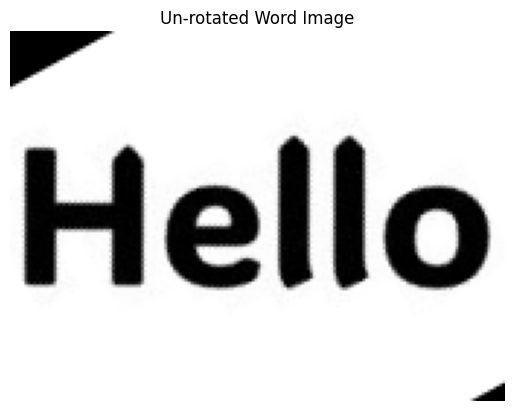

In [14]:
## Make a new demonstration image.
straight_demo = rot_img.copy()

## For each detected text, find the angle of rotation.
for rot_box in rot_result['boxes']:
    ## Obtain the bounding box's dimensions as well as coordinates.
    word_rect = cv2.minAreaRect(rot_box)
    rect_coords = cv2.boxPoints(word_rect)
    rect_coords = np.int0(rect_coords)

    ## Find rotation angle.
    rect_center = (int(word_rect[0][0]), int(word_rect[0][1]))
    if word_rect[1][1] > word_rect[1][0]:
        rot_angle = word_rect[2] - 90
    else:
        rot_angle = word_rect[2]

    ## Un-rotate the image to make sure the word is horizontal.
    rot_mat = cv2.getRotationMatrix2D(center = rect_center, angle = rot_angle, scale = 1.0)
    rot_img = cv2.warpAffine(src = straight_demo, M = rot_mat, dsize = (straight_demo.shape[1], straight_demo.shape[0]))

    ## Extract the image within the bounding box.
    rot_word_img = rot_img[min(rect_coords[:, 1]):max(rect_coords[:, 1]), 
                       min(rect_coords[:, 0]):max(rect_coords[:, 0])]
    
    ## Visualize the un-rotated image.
    plt.imshow(rot_word_img)
    plt.axis('off')
    plt.title("Un-rotated Word Image")
    plt.show()

# Segmenting Characters in Word Images:
## Threshold Segmentation:
In order to segment individual characters in the word image, we'll first use Otsu's Thresholding technique to distinguish the foreground pixels (the words) from the background pixels. This can be done using `opencv`'s built-in functions. We'll first demonstrate the process on the stop sign image.

Before applying the threshold segmentation, we'll first convert the image to greyscale. This is so that the we can work with only one channel and focus on pixel intensity rather that multiple colors. Additionally, we'll add Gaussian blur to the image to remove any noise generated by small particles in the image. These operations are shown below in the `get_char_ver1` function.

In [15]:
## Function covering step one in the preprocessing process.
## Converts image to greyscale and applies Gaussian blur.
def get_char_ver1(word_imgs):
    '''
    Preprocesses images before applying thresholding segmentation.

    Args:
        word_imgs (List): A list containing individual words detected in given image.

    Returns:
        None
    '''
    ## For each word image, apply preprocessing steps.
    for word in word_imgs:
        ## Convert the image into greyscale and apply Gaussian Blur.
        img_grey = cv2.cvtColor(word, cv2.COLOR_BGR2GRAY)
        blur_img = cv2.GaussianBlur(img_grey, (5, 5), 0)

        fig, axs = plt.subplots(1, 2, figsize = (10, 5))

        axs[0].imshow(word)
        axs[0].set_title('Original Image')
        axs[0].axis('off')
        
        axs[1].imshow(blur_img, cmap = 'gray')
        axs[1].set_title('Preprocessed Image')
        axs[1].axis('off')

        plt.tight_layout()
        plt.show()

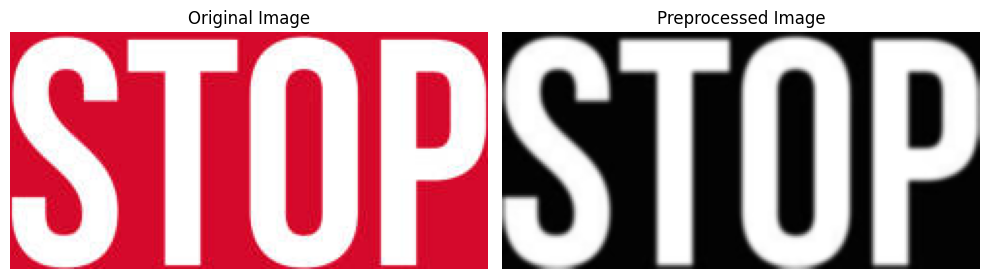

In [16]:
## Convert the image of stop sign into greyscale and apply blur.
get_char_ver1([word_img])

We'll now apply the Otsu's Global Thresholding segmentation technique to clearly distinguish the words from the background. After applying the threshold, we'll have an binary image array where the background pixels are 0 (black) and the foreground pixels are 1 (white). We can then find the contours of the bright pixels based on connectivity. These contours will represent the individual characters in the word using `cv2.findContours`. We will then apply bounding boxes around each contoured shape by using `cv2.boundingRect` to segment the characters. 

The `get_char_ver2` shown below will include these features.

In [17]:
## Function covering step two in the preprocessing process.
## Preprocess image and identify characters.
def get_char_ver2(word_imgs):
    '''
    Preprocesses images before applying thresholding segmentation.

    Args:
        word_imgs (List): A list containing individual words detected in given image.

    Returns:
        None
    '''
    ## For each word image, apply preprocessing steps.
    for word in word_imgs:
        ## Convert the image into greyscale and apply Gaussian Blur.
        img_grey = cv2.cvtColor(word, cv2.COLOR_BGR2GRAY)
        blur_img = cv2.GaussianBlur(img_grey, (5, 5), 0)

        ## Apply Otsu's global thresholding to create binary mask image.
        _, binary_img = cv2.threshold(blur_img, 0, 255, cv2.THRESH_OTSU)

        ## Copy the binary image for demonstration.
        demo_img = binary_img.copy()
        demo_img = cv2.cvtColor(demo_img, cv2.COLOR_GRAY2BGR)

        ## Find contours of segmented characters.
        contours, _ = cv2.findContours(binary_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        ## For each filled contour, extract box image containing character.
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            ## Draw bounding boxes for each rectangle detected.
            cv2.rectangle(demo_img, (x, y), (x + w, y + h), (0, 255, 0), 2)

        fig, axs = plt.subplots(1, 2, figsize = (10, 5))

        axs[0].imshow(blur_img, cmap = 'gray')
        axs[0].set_title('Binary Image')
        axs[0].axis('off')
        
        axs[1].imshow(demo_img)
        axs[1].set_title('Character Segmented Image')
        axs[1].axis('off')

        plt.tight_layout()
        plt.show()

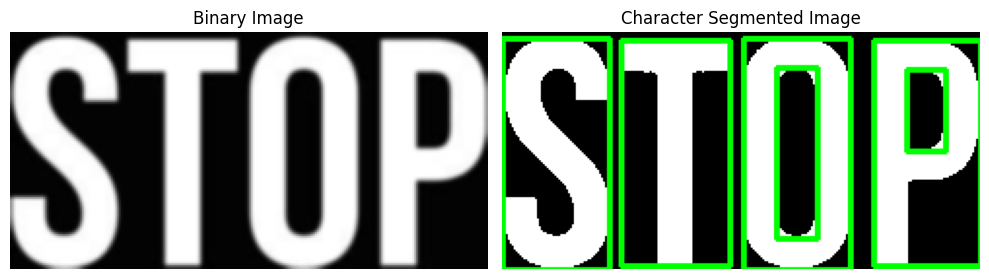

In [18]:
## Segment individual characters based on detected contours.
get_char_ver2([word_img])

There are few problems that needs to be addressed. 

First, because `boundingRect` draws a rectangle encapsulating the contours detected in the image, voids within words (like "o" and "p") can have boxes inside the letter. This can cause an issue when we transfer the segmented characters into our model, since some of the bounding boxes wouldn't contain the entire character. To solve this problem, we can create a separate binary image where contours are filled in. Hence, we'll only be dealing with the outer hull for each character in the image. After obtaining the coordinates for each box in our filled in contour image, we can then use those coordinates on our original binary image to fully segment individual characters.

Second, `boundingRect` draws a rectangle of best fit. Therefore, the rectangle will most likely have discernable differences between the height and the width. When we resize the box containing the characters to be compatible with our model (32x32 images), the character within the box could be significantly stretched and distorted, potentially making it unreconizable. To address this issue, we can resize the longest side of the rectangle to 28 pixels while maintaining aspect ratio. Then, we can add padding on all sides of the border to make a 32x32 image. The resized and padded images can then be used to train or evaluate the character recognition model. 

Finally, `findContours` returns an array of each detected contour of connected images. However, the original array is sorted in the order they were found. So, the contours on the word "S T O P" could be ordered as "P T S O". In order to make sure the characters are properly placed, we can sort the contours based on the x-coordinates or y-coordinates from their detected bounding boxes. This way, the bounding box in the most left will contain the first character while the bounding box on the most right will contain the last character. In doing so, the order of the characters in the word image is preserved.

These modifications are shown below with the function `sort_images`, `resize_pad`, and `get_char_ver3`.

In [19]:
## Sorts images based on their indices.
def sort_images(img_list, index_list):
    '''
    Given a list of images and their corresponding index, sorts the list.

    Args:
        img_list (List): A list containing images.
        index_list (List): A list containing corresponding indices.

    Returns:
        sorted_images (List): A list containing sorted images.
    '''
    ## Initialize list for sorted images.
    sorted_images = []

    ## Pair the image list and index list.
    img_index = list(zip(index_list, img_list))
    ## Sort the paired list based on index.
    sorted_list = sorted(img_index, key = lambda x: x[0])

    ## Save the sorted images into list.
    for index, image in sorted_list:
        sorted_images.append(image)

    ## Return list of sorted images.
    return sorted_images

In [20]:
## Resizes and pads images to be compatible with model.
def resize_pad(img):
    '''
    Resizes the image with respect to the longest side and then pads with background pixels.

    Args:
        img (np.array): An image array containing the image.

    Returns:
        mod_img (np.array): The modified image that is compatible with model.
    '''
    ## Get the width and height of the image.
    height, width = img.shape

    ## If the height is greater than the width, resize height to 28.
    if height > width:
        ## Get the resize factor based on height.
        resize_factor = 28 / height

        ## Resize the character image based on height.
        img_resize = cv2.resize(img, (0, 0), fx = resize_factor, fy = resize_factor)

        ## Set the padding needed for y-axis.
        pad_y = (2, 2)

        ## Determine the total padding needed for the x-axis.
        width_pad = 32 - img_resize.shape[1]

        ## Based on the value of the width pad, determine the amount of padding needed for the left and 
        ## right side of the image.
        if (width_pad) % 2 == 0:
            pad_x = (int(width_pad / 2), int(width_pad / 2))
        if (width_pad) % 2 == 1:
            pad_x = (int(width_pad // 2), int(width_pad // 2) + 1)

    ## If the width is greater than the height, resize width to 28.
    if width >= height:
        ## Get the resize factor based on width.
        resize_factor = 28 / width

        ## Resize the character image based on width.
        img_resize = cv2.resize(img, (0, 0), fx = resize_factor, fy = resize_factor)

        ## Set the padding needed for x-axis.
        pad_x = (2, 2)

        ## Determine the total padding needed for the y-axis.
        height_pad = 32 - img_resize.shape[0]

        ## Based on the value of the height pad, determine the amount of padding needed for the upper and
        ## lower side of the image.
        if (height_pad) % 2 == 0:
            pad_y = (int(height_pad / 2), int(height_pad / 2))
        if (height_pad) % 2 == 1:
            pad_y = (int(height_pad // 2), int(height_pad // 2) + 1)

    ## Pad the image accordingly.
    mod_img = np.pad(img_resize, (pad_y, pad_x), constant_values = 0)

    ## Return resized and padded image.
    return mod_img

In [21]:
## Function covering step three in the preprocessing process.
## Resizing and padding segmented character images.
def get_char_ver3(word_imgs):
    '''
    Applying resize and pad to the segmented character images to be compatible with the model.

    Args:
        word_imgs (List): A list containing individual words detected in given image.

    Returns:
        word_list (List): A list containing characters for each respective word image.
    '''
    ## A list containing characters for each word image.
    word_list = []

    ## For each word image, apply preprocessing steps.
    for word in word_imgs:
        ## Initialize character and indices list.
        char_list = []
        index_list = []

        ## Convert the image into greyscale and apply Gaussian Blur.
        img_grey = cv2.cvtColor(word, cv2.COLOR_BGR2GRAY)
        blur_img = cv2.GaussianBlur(img_grey, (5, 5), 0)

        ## Apply Otsu's global thresholding to create binary mask image.
        _, binary_img = cv2.threshold(blur_img, 0, 255, cv2.THRESH_OTSU)

        ## Copy the binary image for demonstration.
        demo_img = binary_img.copy()
        demo_img = cv2.cvtColor(demo_img, cv2.COLOR_GRAY2BGR)

        ## Find contours of segmented characters.
        contours, _ = cv2.findContours(binary_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        ## Fill in the contours to make sure the insides are not detected.
        mask = np.zeros_like(img_grey)
        for contour in contours:
            cv2.drawContours(mask, [contour], -1, (255), thickness=cv2.FILLED)
        filled_contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        ## For each filled contour, extract box image containing character.
        for filled_contour in filled_contours:
            x, y, w, h = cv2.boundingRect(filled_contour)
            char_img = binary_img[y:y + h, x:x + w]
            char_list.append(resize_pad(char_img))
            
            ## If the characters are aligned horizontally, append x indices.
            if word.shape[1] >= word.shape[0]:
                index_list.append(x)
            ## If the characters are aligned vertically, append y indices.
            else:
                index_list.append(y)

        ## Get sorted images based on the placement of characters.
        sorted_char = sort_images(char_list, index_list)

        ## Append sorted characters into the list of words.
        word_list.append(sorted_char)

        return word_list

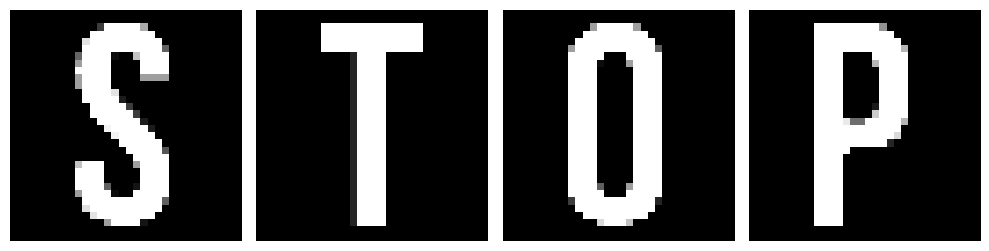

In [22]:
## Get a list of all the characters detected in our test image.
word_chars = get_char_ver3([word_img])

## Determine the number of detected words from the CRAFT algorithm.
num_rows = len(word_chars)

## For each detected word, display their individual characters.
for j in range(num_rows):
    num_cols = len(word_chars[j])

    fig, axs = plt.subplots(num_rows, num_cols, figsize = (10, 10))

    axs = axs.flatten()

    for i in range(len(word_chars[j])):
        axs[i].imshow(word_chars[j][i], cmap = 'gray')
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

## Pixel Intensity Inversion:
Our stop sign image was segmented correctly because after applying the threshold technique, the letters were designated with white pixels while the background was assigned black pixels. Hence, the contours of the images were identified correctly. However, this is not always the case. For example, if our image has the words in black text when the background is white, issues can occur as the contours will only be identified in white pixels. 

To solve this, we'll have to invert the pixel intensity by using the function `cv2.bitwise_not`. This way, our dark text will become bright while our bright background will become dark. Following this, the contours on each characters will be detected accurately. This final modification is shown below with the function `get_char_final` on an image with dark text.

**NOTE:** I couldn't apply an automated way to detect if the foreground was dark or bright. Hence, the user needs to address this when calling the character segmentation function. 

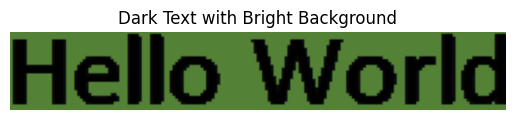

In [23]:
## Define the image path to the dark text image.
dark_path = os.path.join(base_dir, 'datasets', 'images', 'dark_text.png')
## Load in image containing dark text using PIL Image.
dark_img = Image.open(dark_path)
## Convert image to an image array.
dark_img = np.array(dark_img)

## Apply CRAFT algorithm.
dark_result = Craft().detect_text(image = dark_img)

for dark_box in dark_result['boxes']:
    ## Extract the image within the bounding box.
    dark_word_img = dark_img[int(min(dark_box[:, 1])):int(max(dark_box[:, 1])), 
                   int(min(dark_box[:, 0])):int(max(dark_box[:, 0]))]
    
plt.imshow(dark_word_img)
plt.axis('off')
plt.title("Dark Text with Bright Background")
plt.show()

In [24]:
## Obtains the individual characters in a word image detected by CRAFT.
def get_char_final(word_imgs, text_bright = True):
    '''
    Segments individual characters from word images.

    Args:
        word_imgs (List): A list containing individual words detected in given image.
        text_bright (boolean): If the foreground is bright and the background is dark.

    Returns:
        word_list (List): A list containing characters for each respective word image.
    '''
    ## A list containing characters for each word image.
    word_list = []

    ## For each word image, segment characters.
    for word in word_imgs:
        ## Initialize character and indices list.
        char_list = []
        index_list = []

        ## Convert the image into greyscale and apply Gaussian Blur.
        img_grey = cv2.cvtColor(word, cv2.COLOR_BGR2GRAY)
        blur_img = cv2.GaussianBlur(img_grey, (5, 5), 0)

        ## Apply Otsu's global thresholding to create binary mask image.
        _, binary_img = cv2.threshold(blur_img, 0, 255, cv2.THRESH_OTSU)

        ## If the background is bright and the foreground is dark, invert the image to 
        ## correctly draw contours.
        if not text_bright:
            binary_img = cv2.bitwise_not(binary_img)

        ## Find contours of segmented characters.
        contours, _ = cv2.findContours(binary_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        ## Fill in the contours to make sure the insides are not detected.
        mask = np.zeros_like(img_grey)
        for contour in contours:
            cv2.drawContours(mask, [contour], -1, (255), thickness=cv2.FILLED)
        filled_contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        ## For each filled contour, extract box image containing character.
        for filled_contour in filled_contours:
            x, y, w, h = cv2.boundingRect(filled_contour)
            char_img = binary_img[y:y + h, x:x + w]
            char_list.append(resize_pad(char_img))

            ## If the characters are aligned horizontally, append x indices.
            if word.shape[1] >= word.shape[0]:
                index_list.append(x)
            ## If the characters are aligned vertically, append y indices.
            else:
                index_list.append(y)

        ## Get sorted images based on the placement of characters.
        sorted_char = sort_images(char_list, index_list)

        ## Append sorted characters into the list of words.
        word_list.append(sorted_char)

    ## Return the sorted character images.
    return word_list

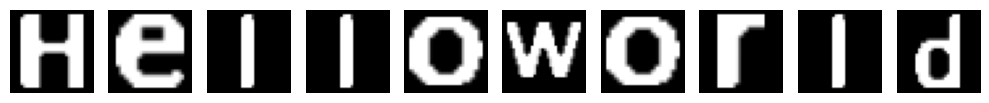

In [25]:
## Get a list of all the characters detected in our rotated text image.
word_chars = get_char_final([dark_word_img], text_bright = False)

## Determine the number of detected words from the CRAFT algorithm.
num_rows = len(word_chars)

## For each detected word, display their individual characters.
for j in range(num_rows):
    num_cols = len(word_chars[j])

    fig, axs = plt.subplots(num_rows, num_cols, figsize = (10, 10))

    axs = axs.flatten()

    for i in range(len(word_chars[j])):
        axs[i].imshow(word_chars[j][i], cmap = 'gray')
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()